In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.algo_base import AlgoBase

In [2]:
#! wget https://files.grouplens.org/datasets/movielens/ml-20m.zip
#! unzip ml-20m.zip


In [3]:
column_names = ['movieId', 'title', 'genres']
movies = pd.read_csv('/Users/admin/Downloads/hw/task4/ml-20m/movies.csv')[:50000]


In [4]:
column_names = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('/Users/admin/Downloads/hw/task4/ml-20m/ratings.csv')[:100000]

In [5]:
column_names = ['userId', 'movieId', 'tag', 'timestamp']

tags = pd.read_csv('/Users/admin/Downloads/hw/task4/ml-20m/tags.csv')[:100000]

In [6]:
print("\nMovies Data :")
print("shape : ", movies.shape)
print(movies.head())


Movies Data :
shape :  (27278, 3)
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [7]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [8]:
print("\nRatings Data :")
print("shape : ", ratings.shape)
print(ratings.head())


Ratings Data :
shape :  (100000, 4)
   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580


In [9]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
99995,702,1373,3.0,1095142579
99996,702,1374,2.5,1095136686
99997,702,1377,1.5,1095141779
99998,702,1378,1.5,1095139088


In [10]:
print("\nTags Data :")
print("shape : ", tags.shape)
print(tags.head())


Tags Data :
shape :  (100000, 4)
   userId  movieId            tag   timestamp
0      18     4141    Mark Waters  1240597180
1      65      208      dark hero  1368150078
2      65      353      dark hero  1368150079
3      65      521  noir thriller  1368149983
4      65      592      dark hero  1368150078


In [11]:
tags

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
...,...,...,...,...
99995,25737,1805,Nudity (Topless),1296955688
99996,25737,1805,plot twist,1296955691
99997,25737,1805,pulp,1296955693
99998,25737,1805,sexy,1296955718


In [12]:
from sklearn.model_selection import train_test_split
r_cols = ['userId', 'movieId', 'rating', 'timestamp']

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Display the shapes of the resulting DataFrames
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (80000, 4)
Testing data shape: (20000, 4)


In [13]:
train_data.shape, test_data.shape

((80000, 4), (20000, 4))

In [14]:
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [15]:
n_users = ratings['movieId'].nunique()
print("Number of unique movies:", n_users)

Number of unique movies: 8227


In [16]:
n_users

8227

In [17]:
n_tags = ratings.movieId.unique().shape[0]
n_tags

8227

In [18]:
from scipy.sparse import csr_matrix
user_movies_data = ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
user_movies_data


userId,1,2,3,4,5,6,7,8,9,10,...,693,694,695,696,697,698,699,700,701,702
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.0,4.5,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.5
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,3.5,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Content Filtering

In [19]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [20]:
movies['metadata'] = " "

In [21]:
movies

,movieId,title,genres,metadata
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,
1,2,Jumanji (1995),Adventure|Children|Fantasy,
2,3,Grumpier Old Men (1995),Comedy|Romance,
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,
4,5,Father of the Bride Part II (1995),Comedy,
...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,
27275,131258,The Pirates (2014),Adventure,
27276,131260,Rentun Ruusu (2001),(no genres listed),


In [22]:
Action = movies[movies['genres'] == 'Action']
Action

,movieId,title,genres,metadata
8,9,Sudden Death (1995),Action,
70,71,Fair Game (1995),Action,
202,204,Under Siege 2: Dark Territory (1995),Action,
248,251,"Hunted, The (1995)",Action,
659,667,Bloodsport 2 (a.k.a. Bloodsport II: The Next K...,Action,
...,...,...,...,...
26876,129239,The Monkey Hustle (1976),Action,
26899,129346,The Package (2012),Action,
26965,129657,Tracers (2015),Action,
27139,130526,The Detective 2 (2011),Action,


In [23]:
print(movies.columns)

Index(['movieId', 'title', 'genres', 'metadata'], dtype='object')


In [24]:
Action = movies[movies['genres'] == 'Action']
print(Action)


       movieId                                              title  genres  \
8            9                                Sudden Death (1995)  Action   
70          71                                   Fair Game (1995)  Action   
202        204               Under Siege 2: Dark Territory (1995)  Action   
248        251                                 Hunted, The (1995)  Action   
659        667  Bloodsport 2 (a.k.a. Bloodsport II: The Next K...  Action   
...        ...                                                ...     ...   
26876   129239                           The Monkey Hustle (1976)  Action   
26899   129346                                 The Package (2012)  Action   
26965   129657                                     Tracers (2015)  Action   
27139   130526                             The Detective 2 (2011)  Action   
27198   131025                            The Brass Legend (1956)  Action   

      metadata  
8               
70              
202             
248    

In [25]:
movies['Action'] = (movies['genres'] == 'Action').astype(int)
print(movies['Action'])

0        0
1        0
2        0
3        0
4        0
        ..
27273    0
27274    0
27275    0
27276    0
27277    0
Name: Action, Length: 27278, dtype: int64


In [26]:
def metadata_Action(x):
    if x == 1:
        return "Action"
    else:
        return " "
movies['metadata_Action'] = movies.Action.apply(metadata_Action)     

In [27]:
movies

,movieId,title,genres,metadata,Action,metadata_Action
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,,0,
1,2,Jumanji (1995),Adventure|Children|Fantasy,,0,
2,3,Grumpier Old Men (1995),Comedy|Romance,,0,
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,,0,
4,5,Father of the Bride Part II (1995),Comedy,,0,
...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,,0,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,,0,
27275,131258,The Pirates (2014),Adventure,,0,
27276,131260,Rentun Ruusu (2001),(no genres listed),,0,


In [28]:
movies['Drama'] = (movies['genres'] == 'Drama').astype(int)
print(movies['Drama'])

0        0
1        0
2        0
3        0
4        0
        ..
27273    0
27274    0
27275    0
27276    0
27277    0
Name: Drama, Length: 27278, dtype: int64


In [29]:
def metadata_Drama(x):
    if x == 1:
        return "Drama"
    else:
        return " "
movies['metadata_Drama'] = movies.Action.apply(metadata_Drama)  


In [30]:
genres = ['Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [31]:
def get_genres(series):
    return series['genres'].replace("|", " ")

In [32]:
movies['metadata'] = movies.apply(get_genres, axis=1)
movies

,movieId,title,genres,metadata,Action,metadata_Action,Drama,metadata_Drama
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,0,,0,
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,0,,0,
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,0,,0,
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,0,,0,
4,5,Father of the Bride Part II (1995),Comedy,Comedy,0,,0,
...,...,...,...,...,...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy,Comedy,0,,0,
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy,Comedy,0,,0,
27275,131258,The Pirates (2014),Adventure,Adventure,0,,0,
27276,131260,Rentun Ruusu (2001),(no genres listed),(no genres listed),0,,0,


TF-IDF Vectorizer on Metadata

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['title'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)

(27278, 21709)


In [34]:
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,21699,21700,21701,21702,21703,21704,21705,21706,21707,21708
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


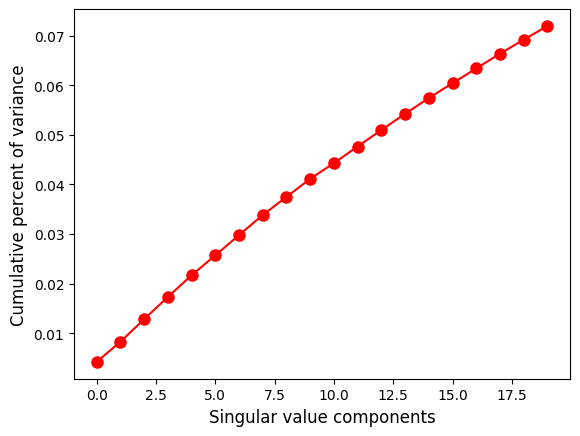

In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=20)
latent_matrix_1 = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [36]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix_1[:len(movies), 0:n], index=movies['title'].tolist())

latent_matrix_1_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Toy Story (1995),0.018636,0.019817,0.005760,0.004445,0.010949,0.012238,0.008540,0.005258,0.017867,0.007479,0.025971,0.015145,0.009680,0.013210,0.018948,0.039973,0.020732,0.000279,0.178774,-0.174354
Jumanji (1995),0.005507,0.006659,0.001803,0.002705,0.003022,0.006139,0.003744,0.003385,0.011137,0.006555,0.016756,0.009127,0.007845,0.010191,0.011285,0.031888,0.015218,-0.002271,0.168686,-0.185081
Grumpier Old Men (1995),0.012275,0.012081,0.004631,0.005975,0.007328,0.009709,0.005259,0.006697,0.015924,0.005094,0.022383,0.008423,0.010664,0.012525,0.015138,0.038937,0.003114,0.001187,0.131378,-0.143721
Waiting to Exhale (1995),0.005558,0.008132,0.001330,0.004855,0.004034,0.005585,0.002271,0.002481,0.009593,0.007701,0.014544,0.007420,0.005945,0.009548,0.008553,0.026240,0.014572,-0.003569,0.136552,-0.149508
Father of the Bride Part II (1995),0.012402,0.015130,0.006534,0.006966,0.005653,0.014697,0.007545,0.000717,0.018370,0.007982,0.027610,0.009239,0.007552,0.010100,0.013046,0.035795,0.020062,0.003273,0.157306,-0.158008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kein Bund für's Leben (2007),0.014166,0.022230,0.007962,0.011958,0.016005,0.200790,-0.087689,-0.027265,-0.021612,-0.009121,-0.012122,-0.003363,-0.002869,-0.004421,-0.004202,-0.005069,-0.004020,-0.000655,-0.006693,0.002478
"Feuer, Eis & Dosenbier (2002)",0.004939,0.006575,0.002440,0.003356,0.002454,0.005959,0.004526,0.003241,0.013492,0.010694,0.178138,-0.158040,-0.049646,-0.039167,-0.022445,-0.017158,-0.008053,-0.001965,-0.011667,-0.003461
The Pirates (2014),0.024960,0.036636,0.013256,0.015861,0.022875,0.092518,0.116070,0.450995,-0.061671,-0.023773,-0.030873,-0.007682,-0.005943,-0.011444,-0.008694,-0.012069,-0.007562,0.001693,-0.010265,0.004912
Rentun Ruusu (2001),0.005839,0.007313,0.002855,0.002904,0.003037,0.006958,0.005478,0.003189,0.016305,0.015244,0.095235,0.069622,0.256447,-0.101362,-0.034040,-0.022730,-0.015768,-0.002761,-0.019343,0.002285


In [37]:
latent_matrix_1_df.shape

(27278, 20)

Collaborative filtering

In [38]:
from sklearn.decomposition import TruncatedSVD
from surprise.model_selection import train_test_split
import pandas as pd

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

svd_model = SVD(n_factors=20, random_state=42)
svd_model.fit(trainset)

latent_matrix_2 = svd_model.pu

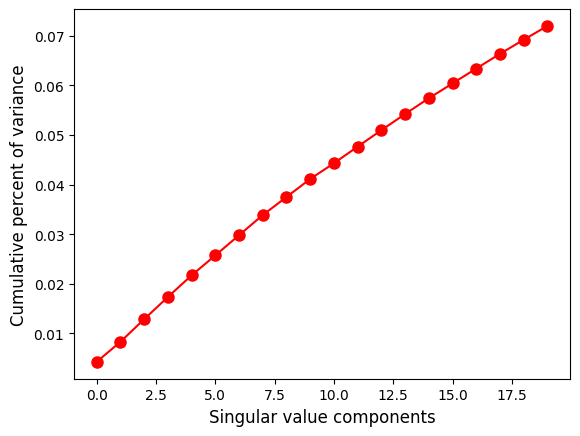

In [39]:
latent_matrix_2 = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [40]:
n = 19
latent_matrix_2_df = pd.DataFrame(latent_matrix_2[:, :n], index=ratings['movieId'][:27278].tolist())

In [41]:
latent_matrix_2_df.shape

(27278, 19)

In [42]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2,0.018791,0.019682,0.005857,0.004272,0.011209,0.012597,0.008118,0.005699,0.017630,0.006112,0.025730,0.015919,0.006684,0.013227,0.021209,0.051134,-0.006828,0.024138,0.106491
29,0.005716,0.006574,0.001892,0.002524,0.003604,0.006537,0.003188,0.003384,0.010908,0.004252,0.017534,0.008393,0.005283,0.010256,0.011311,0.042347,-0.002006,0.024730,0.096108
32,0.012444,0.012199,0.004660,0.005834,0.007696,0.009273,0.004689,0.006485,0.015342,0.002912,0.023198,0.008031,0.007334,0.011787,0.016730,0.045936,0.008997,0.014789,0.078144
47,0.005728,0.008062,0.001396,0.004697,0.004515,0.005927,0.001819,0.002455,0.009416,0.005825,0.015092,0.006780,0.003869,0.009665,0.008564,0.034694,-0.002493,0.022814,0.077459
50,0.012607,0.015177,0.006417,0.006977,0.006136,0.014749,0.006684,0.001420,0.018233,0.006023,0.029518,0.009699,0.005411,0.009498,0.014606,0.049273,-0.007738,0.020383,0.091649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0.014203,0.022223,0.007623,0.011824,0.016229,0.201457,-0.086420,-0.027073,-0.021771,-0.009261,-0.012452,-0.003271,-0.002802,-0.004543,-0.004897,-0.006759,0.002451,-0.001525,-0.005073
589,0.005057,0.006438,0.002407,0.003191,0.002518,0.006755,0.004354,0.003452,0.014128,0.010911,0.177136,-0.159426,-0.054245,-0.035387,-0.021359,-0.017746,0.001771,-0.001880,-0.005471
593,0.024984,0.036670,0.012986,0.016148,0.022549,0.090858,0.115408,0.451430,-0.060287,-0.024158,-0.032035,-0.008773,-0.005416,-0.010885,-0.011541,-0.017584,0.003795,-0.004478,-0.008003
594,0.005861,0.007296,0.002591,0.002811,0.003201,0.006976,0.005068,0.003206,0.017187,0.015513,0.095123,0.054284,0.261681,-0.097006,-0.037600,-0.027803,0.007032,-0.006329,-0.012722


Hybrid Recommendation System

In [43]:
class Hybrid(AlgoBase):
    def __init__(self, svd_model, knn_model, sim_options={}, bsl_options={}, verbose=True):
        AlgoBase.__init__(self, sim_options=sim_options, bsl_options=bsl_options, verbose=verbose)
        self.svd_model = svd_model
        self.knn_model = knn_model

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.svd_model.fit(trainset)
        self.knn_model.fit(trainset)
        return self

    def estimate(self, u, i):
        svd_prediction = self.svd_model.predict(u, i).est
        knn_prediction = self.knn_model.predict(u, i).est
        return (svd_prediction + knn_prediction) / 2

knn_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
svd_model = SVD(n_factors=50, random_state=42)

hybrid_model = Hybrid(svd_model, knn_model)
hybrid_model.fit(trainset)


test_predictions = hybrid_model.test(testset)
accuracy.rmse(test_predictions, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1374


1.1374471854400259

In [44]:
def recommend_similar_movies(movie_title, movies, latent_matrix, tfidf_vectorizer):
    # Get the index of the provided movie title
    movie_indices = movies.index[movies['title'] == movie_title].tolist()

    if not movie_indices:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    idx = movie_indices[0]
    
    cosine_similarities = cosine_similarity(latent_matrix, latent_matrix[idx].reshape(1, -1)).flatten()

    similar_movies_indices = cosine_similarities.argsort()[::-1]

    similar_movies_indices = [i for i in similar_movies_indices if i != idx]

    if len(similar_movies_indices) < 5:
        print("Not enough movies in the dataset for recommendations.")
        return []

    similar_movies_indices = similar_movies_indices[:5]
    similar_movies = movies.iloc[similar_movies_indices]['title'].tolist()
    return similar_movies

In [45]:
similar_movies = recommend_similar_movies("Toy Story (1995)", movies, latent_matrix_1, tfidf)
print("Recommended movies for Toy Story (1995):")
for movie in similar_movies:
    print(movie)

Recommended movies for Toy Story (1995):
Lilian's Story (1995)
Hundred and One Nights, A (Cent et une nuits de Simon Cinéma, Les) (1995)
Hate (Haine, La) (1995)
Father of the Bride Part II (1995)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995)


In [46]:
similar_movies = recommend_similar_movies(("GoldenEye (1995)"), movies, latent_matrix_1, tfidf)
print("Recommended movies for GoldenEye (1995)")
for movie in similar_movies:
    print(movie)

Recommended movies for GoldenEye (1995)
Fantasticks, The (1995)
Fluke (1995)
Virtuosity (1995)
Copycat (1995)
Honeymoons (1995)


In [47]:
similar_movies = recommend_similar_movies(("Mission: Impossible (1996)"), movies, latent_matrix_1, tfidf)
print("Recommended movies for Mission: Impossible (1996)")
for movie in similar_movies:
    print(movie)

Recommended movies for Mission: Impossible (1996)
Ebola Syndrome, The (Yi boh laai beng duk) (1996)
Chain Reaction (1996)
Scream (1996)
When We Were Kings (1996)
Crocodile (Ag-o) (1996)


Popularity

In [48]:
import pandas as pd

In [49]:
average_ratings = ratings.groupby('movieId')['rating'].mean()

popularity_recommendations = average_ratings.sort_values(ascending=False).index

movies_titles = movies[['movieId', 'title']]
popularity_recommendations = pd.merge(pd.DataFrame(popularity_recommendations, columns=['movieId']), movies_titles, on='movieId')['title']

In [50]:
print("Popularity Recommendations (based on average ratings):")
print(popularity_recommendations)

Popularity Recommendations (based on average ratings):
0                    Hour of the Wolf (Vargtimmen) (1968)
1       His Secret Life (a.k.a. Ignorant Fairies, The)...
2                                        Hopscotch (1980)
3                        Comfort of Strangers, The (1990)
4                                  Shogun Assassin (1980)
                              ...                        
8222               Better Living Through Chemistry (2014)
8223    Starship Troopers 2: Hero of the Federation (2...
8224                                        Oldboy (2013)
8225                                  It Takes Two (1995)
8226                                Boy Meets Girl (2015)
Name: title, Length: 8227, dtype: object


In [51]:
print(popularity_recommendations.head(25))

0                  Hour of the Wolf (Vargtimmen) (1968)
1     His Secret Life (a.k.a. Ignorant Fairies, The)...
2                                      Hopscotch (1980)
3                      Comfort of Strangers, The (1990)
4                                Shogun Assassin (1980)
5                                   Live Forever (2003)
6                                   Gambler, The (1974)
7                                     Ratcatcher (1999)
8                     Scarlet and the Black, The (1983)
9                                          Yentl (1983)
10                    Incredible Mr. Limpet, The (1964)
11                                 Chaos (Kaosu) (1999)
12                              Teddy Bear (Mis) (1981)
13                                        Exodus (1960)
14    Russians Are Coming, the Russians Are Coming, ...
15                    World of Henry Orient, The (1964)
16                              Murder, My Sweet (1944)
17            Spy Who Came in from the Cold, The

In [52]:
user_ids = [1, 2, 3, 4, 5]
user_recommendations = pd.DataFrame({'userId': [], 'movieId': []})

for user_id in user_ids:
    user_recommendations = pd.concat([user_recommendations, pd.DataFrame({'userId': [user_id] * len(popularity_recommendations), 'movieId': popularity_recommendations.tolist()})])

In [53]:
print("User-specific Recommendations (Popularity-based):")
print(user_recommendations)


User-specific Recommendations (Popularity-based):
      userId                                            movieId
0        1.0               Hour of the Wolf (Vargtimmen) (1968)
1        1.0  His Secret Life (a.k.a. Ignorant Fairies, The)...
2        1.0                                   Hopscotch (1980)
3        1.0                   Comfort of Strangers, The (1990)
4        1.0                             Shogun Assassin (1980)
...      ...                                                ...
8222     5.0             Better Living Through Chemistry (2014)
8223     5.0  Starship Troopers 2: Hero of the Federation (2...
8224     5.0                                      Oldboy (2013)
8225     5.0                                It Takes Two (1995)
8226     5.0                              Boy Meets Girl (2015)

[41135 rows x 2 columns]


Turicreate

In [54]:
#! pip install turicreate

In [55]:
import turicreate

In [56]:
train_data = turicreate.SFrame(ratings_train)
test_data = turicreate.SFrame(ratings_test)

NameError: name 'ratings_train' is not defined

In [ ]:
popularity_model = turicreate.popularity_recommender.create(train_data, userId='userId', itemId='movieId', target='rating')

In [ ]:
popularity_recomm = popularity_model.recommend(users=[1,2,3,4,5],k=5)
popularity_recomm.print_rows(num_rows=25)

In [ ]:
item_sim_model = turicreate.item_similarity_recommender.create(train_data, userId='userId', itemId='movieId', target='rating', similarity_type='cosine')

In [ ]:
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

In [ ]:
item_sim_model = turicreate.item_similarity_recommender.create(train_data, userId='userId', itemId='movieId', target='rating', similarity_type='cosine')

In [ ]:
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

Matrix Factorization Recommender

In [57]:
import numpy as np

In [58]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])


    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction


    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [59]:
R= np.array(ratings_subset.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

NameError: name 'ratings_subset' is not defined

In [ ]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

Iteration: 20 ; error = 283.2031
Iteration: 40 ; error = 276.6454
Iteration: 60 ; error = 271.9114
Iteration: 80 ; error = 265.9081
Iteration: 100 ; error = 256.3696

P x Q:
[[3.98299712 3.36206837 3.26193069 ... 3.05757985 3.53497794 3.35328828]
 [4.38742498 3.80126673 3.69371286 ... 3.53726987 3.89506911 3.7503292 ]
 [4.42574708 3.78922501 3.75463701 ... 3.50532387 3.96512645 3.79953337]
 ...
 [3.57051863 2.9886603  2.88895539 ... 2.78720878 3.1188618  3.01935159]
 [3.82676305 3.18040845 3.07970662 ... 2.97236658 3.33267735 3.1792986 ]
 [3.17723623 2.54327287 2.29976159 ... 2.27344397 2.59219389 2.43318006]]



Surprise

In [60]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [61]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
99995,702,1373,3.0,1095142579
99996,702,1374,2.5,1095136686
99997,702,1377,1.5,1095141779
99998,702,1378,1.5,1095139088


In [62]:
tags

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
...,...,...,...,...
99995,25737,1805,Nudity (Topless),1296955688
99996,25737,1805,plot twist,1296955691
99997,25737,1805,pulp,1296955693
99998,25737,1805,sexy,1296955718


In [63]:
mapping_movie_file = dict(zip(movies['title'], movies['movieId']))
mapping_movie_file

{'Toy Story (1995)': 1,
 'Jumanji (1995)': 2,
 'Grumpier Old Men (1995)': 3,
 'Waiting to Exhale (1995)': 4,
 'Father of the Bride Part II (1995)': 5,
 'Heat (1995)': 6,
 'Sabrina (1995)': 7,
 'Tom and Huck (1995)': 8,
 'Sudden Death (1995)': 9,
 'GoldenEye (1995)': 10,
 'American President, The (1995)': 11,
 'Dracula: Dead and Loving It (1995)': 12,
 'Balto (1995)': 13,
 'Nixon (1995)': 14,
 'Cutthroat Island (1995)': 15,
 'Casino (1995)': 16,
 'Sense and Sensibility (1995)': 17,
 'Four Rooms (1995)': 18,
 'Ace Ventura: When Nature Calls (1995)': 19,
 'Money Train (1995)': 20,
 'Get Shorty (1995)': 21,
 'Copycat (1995)': 22,
 'Assassins (1995)': 23,
 'Powder (1995)': 24,
 'Leaving Las Vegas (1995)': 25,
 'Othello (1995)': 26,
 'Now and Then (1995)': 27,
 'Persuasion (1995)': 28,
 'City of Lost Children, The (Cité des enfants perdus, La) (1995)': 29,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 30,
 'Dangerous Minds (1995)': 31,
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)':

In [64]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9076


0.9076430154062419

In [65]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in mapping_movie_file.items() if not v in ui_list}
        predictedL = []
        for i, j in d.items():
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3]))
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)
        pdf.set_index('movies', inplace=True)
        return pdf.head(10)
    else:
        print("User Id does not exist in the list!")
        return None

In [66]:
userId = 1
pred_user_rating(userId)

,ratings
movies,
"Godfather: Part II, The (1974)",4.493161
Schindler's List (1993),4.420390
City of God (Cidade de Deus) (2002),4.396433
Wallace & Gromit: The Wrong Trousers (1993),4.383467
Seven Samurai (Shichinin no samurai) (1954),4.379927
Eternal Sunshine of the Spotless Mind (2004),4.369624
"Godfather, The (1972)",4.361917
"Treasure of the Sierra Madre, The (1948)",4.360222
"Philadelphia Story, The (1940)",4.354887


In [67]:
pred_user_rating(50)

,ratings
movies,
"Godfather: Part II, The (1974)",4.768133
"Godfather, The (1972)",4.748819
Life Is Beautiful (La Vita è bella) (1997),4.715790
"Usual Suspects, The (1995)",4.714530
Chinatown (1974),4.701825
Rear Window (1954),4.699022
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.687993
"Philadelphia Story, The (1940)",4.665738
Schindler's List (1993),4.663560


In [68]:
pred_user_rating(91)

,ratings
movies,
"Dark Knight, The (2008)",4.163309
"Maltese Falcon, The (1941)",4.158484
Léon: The Professional (a.k.a. The Professional) (Léon) (1994),4.113328
"Postman, The (Postino, Il) (1994)",4.094590
Chinatown (1974),4.080532
Band of Brothers (2001),4.076007
Mr. Smith Goes to Washington (1939),4.062798
Casablanca (1942),4.060377
"Lives of Others, The (Das leben der Anderen) (2006)",4.044839


In [69]:
pred_user_rating(48)

,ratings
movies,
"Dark Knight, The (2008)",4.488489
Rear Window (1954),4.484884
Vertigo (1958),4.464378
"Lives of Others, The (Das leben der Anderen) (2006)",4.460878
Casablanca (1942),4.372661
Before Sunset (2004),4.371222
"Bourne Ultimatum, The (2007)",4.369029
Butch Cassidy and the Sundance Kid (1969),4.337797
"Shining, The (1980)",4.336390


In [70]:
pred_user_rating(5)

,ratings
movies,
Schindler's List (1993),4.959782
Fight Club (1999),4.932669
Forrest Gump (1994),4.928031
Eternal Sunshine of the Spotless Mind (2004),4.921219
City of God (Cidade de Deus) (2002),4.903852
"Usual Suspects, The (1995)",4.889192
"Godfather, The (1972)",4.888533
Dr. Horrible's Sing-Along Blog (2008),4.868504
"Godfather: Part II, The (1974)",4.830533
